In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### Cohort Analysis:

In [ ]:
# Import the data and inspect on it:

df = pd.read_csv("online.csv")
df.head(3)

In [ ]:
df.info()

In [ ]:
# Get the sum column for each order
df['InvoiceSum'] = df['UnitPrice']*df['Quantity']

# Get the datetime format for InvoiceDate
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
def get_date(x):
    date = dt.date(x.year, x.month, 1)
    return date

# Apply the function to the InvoiceDate column by using the apply() function.
# sidenote: apply() passes a function along an axis of the DataFrame.

df['InvoiceDate'] = df['InvoiceDate'].apply(get_date)

x = df['InvoiceDate'].apply(get_date)

x

In [ ]:
# We first groupby CustomerID, then apply min func on the InvoiceDate to each group of IDs. transform() will return
# a pd.Series with the same length of the original dataframe b4 groupby.

df['CohortDate'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')

In [ ]:
# Create functions that return the year and the month for a datetime object:
def get_year(x):
    year = x.year
    return year

def get_month(x):
    month = x.month
    return month

# Apply funcs on InvoiceDate and CohortDate

invoice_year = df['InvoiceDate'].apply(get_year)
invoice_month = df['InvoiceDate'].apply(get_month)

cohort_year = df['CohortDate'].apply(get_year)
cohort_month = df['CohortDate'].apply(get_month)

# Now we can calculate the difference between each pair of invoice date and cohort date in years and months:

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month
total_diff = year_diff*12+month_diff

df['Diff'] = total_diff

df.head(3)

In [1]:
grouping = df.groupby(['CohortDate', 'Diff']).agg({'CustomerID' : 'nunique'}).reset_index()
grouping

NameError: name 'df' is not defined

In [ ]:
grouping.pivot(index = 'CohortDate', columns = 'Diff', values = 'CustomerID')

### KMeans Clustering:

In [3]:
# Import the dataset

data = pd.read_csv('rfm_datamart.csv')

data.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12747,3,25,948.70
1,12748,1,888,7046.16
2,12749,4,37,813.45
3,12820,4,17,268.02
4,12822,71,9,146.15


In [4]:
data.shape

(3643, 4)

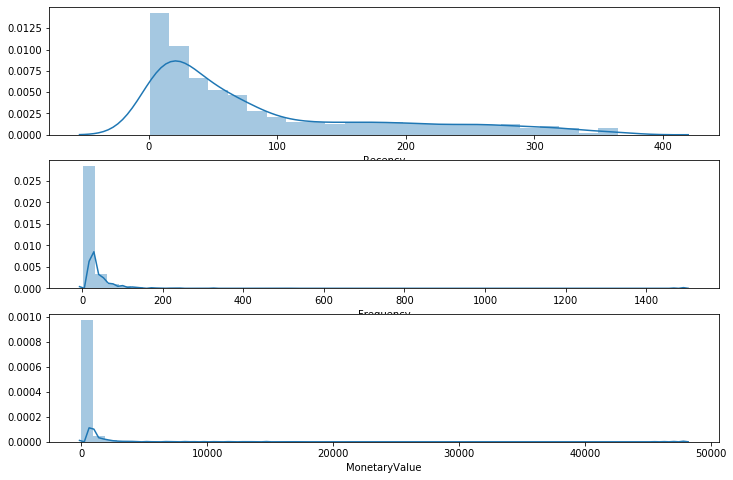

In [5]:
plt.figure(figsize = (12,8))

# Plot recency distribution
plt.subplot(3, 1, 1); 
sns.distplot(data['Recency'])

# Plot frequency distribution
plt.subplot(3,1,2); 
sns.distplot(data['Frequency'])

# Plot monetary value distribution
plt.subplot(3,1,3); 
sns.distplot(data['MonetaryValue'])


In [6]:
# Drop the CustomerID column before we unskew and scale the data

data1 = data.drop('CustomerID', axis = 1)

data1.head()

,Recency,Frequency,MonetaryValue
0,3,25,948.70
1,1,888,7046.16
2,4,37,813.45
3,4,17,268.02
4,71,9,146.15


In [7]:
# Unskew the data
data1_log = np.log(data1)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data1_log)

# Scale and center the data
data1_norm = scaler.transform(data1_log)

# Combine the CustomerID column with the scaled and unskewed data
data2 = pd.concat([data['CustomerID'], pd.DataFrame(data1_norm), ], axis = 1)

data2 = data2.rename(columns = {0 : 'Recency', 1 : 'Frequency', 2: 'MonetaryValue'})

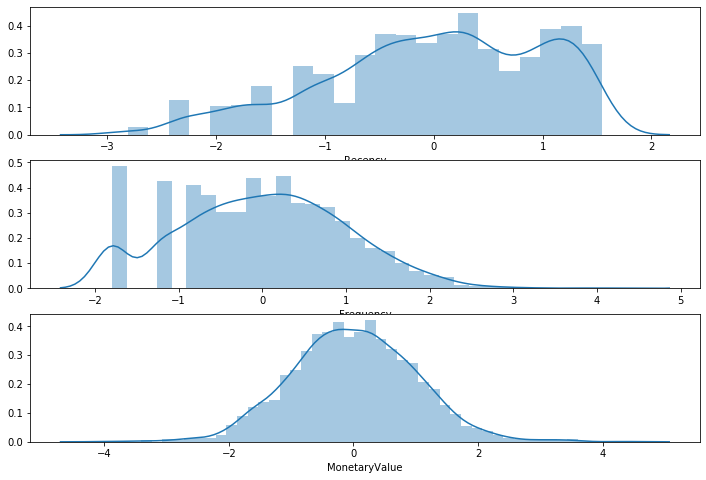

In [8]:
plt.figure(figsize = (12,8))

# Plot recency distribution
plt.subplot(3, 1, 1)
sns.distplot(data2['Recency'])

# Plot frequency distribution
plt.subplot(3,1,2)
sns.distplot(data2['Frequency'])

# Plot monetary value distribution
plt.subplot(3,1,3)
sns.distplot(data2['MonetaryValue'])


In [54]:
# Run KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(data2)

# Extract cluster labels
cluster_labels = kmeans.labels_


In [10]:
# Create a DataFrame by adding a new cluster label column
data3 = data2.assign(Cluster = cluster_labels)

In [11]:
# Calculate average RFM values and segment sizes per cluster value
data3.groupby('Cluster').agg({'Recency' : 'mean',
                             'Frequency' : 'mean',
                             'MonetaryValue' : ['mean', 'count']}).round(3)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         0.024    -0.019        -0.016  1231
1        -0.003     0.004         0.066  1229
2        -0.021     0.016        -0.051  1183

In [12]:
# Calculate and store the sum of squared errors for different numbers of clusters
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data2)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

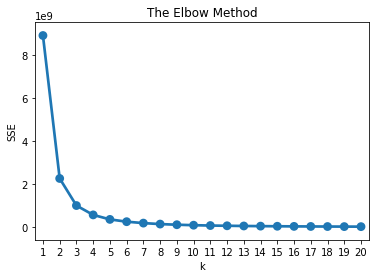

In [13]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [16]:
data3.head()

,CustomerID,Recency,Frequency,MonetaryValue,Cluster
0,12747,-2.002202,0.865157,1.464940,1
1,12748,-2.814518,3.815272,2.994692,1
2,12749,-1.789490,1.189117,1.347598,1
3,12820,-1.789490,0.546468,0.500595,1
4,12822,0.337315,0.020925,0.037943,1


In [19]:
# Melt the normalized dataset and reset the index
data_melt = pd.melt(data3,
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

data_melt.head()

,CustomerID,Cluster,Metric,Value
0,12747,1,Recency,-2.002202
1,12748,1,Recency,-2.814518
2,12749,1,Recency,-1.789490
3,12820,1,Recency,-1.789490
4,12822,1,Recency,0.337315


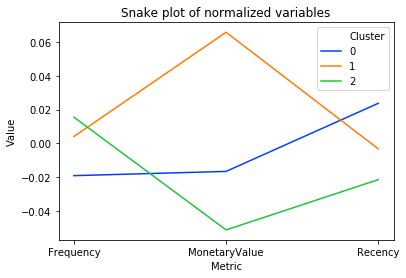

In [23]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=data_melt, x='Metric', y='Value', hue='Cluster', palette = 'bright', ci=None)
plt.show()

In [56]:
data_rfm = data1.assign(Cluster = cluster_labels)

data_rfm.head()

,Recency,Frequency,MonetaryValue,Cluster
0,3,25,948.70,1
1,1,888,7046.16,1
2,4,37,813.45,1
3,4,17,268.02,1
4,71,9,146.15,1


In [49]:
cluster_avg = data_rfm.groupby('Cluster').mean()

pop_avg = data1.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_diff = round(cluster_avg.divide(pop_avg, axis = 1),3)

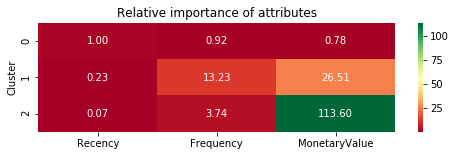

In [50]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_diff, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()